In [12]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, fixed 
from IPython.display import display # Nécessaire pour afficher explicitement dans certains environnements

# Note: Ce code est conçu pour être exécuté dans un environnement Jupyter Notebook/Lab

def construire_hamiltonien_zigzag(k, N, t=1.0):
    """
    Construit la matrice Hamiltonienne H(k) pour un nanoruban zigzag.
    (Identique à la version précédente)
    """
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=complex)
    gamma_k = 1 + np.exp(-1j * k)
    gamma_k_conj = np.conjugate(gamma_k)

    for m in range(N):
        idx_a = 2 * m
        idx_b = 2 * m + 1
        H[idx_a, idx_b] = -t * gamma_k
        H[idx_b, idx_a] = -t * gamma_k_conj

    for m in range(N - 1):
        idx_b_m = 2 * m + 1
        idx_a_m_plus_1 = 2 * (m + 1)
        H[idx_a_m_plus_1, idx_b_m] = -t
        H[idx_b_m, idx_a_m_plus_1] = -t

    return H

def calculer_bandes_zigzag(N, t=1.0, num_k_points=1000):
    """
    Calcule les énergies (valeurs propres) pour une plage de k de -pi à pi.

    Args:
        N (int): Largeur du ruban.
        t (float): Intégrale de saut.
        num_k_points (int): Nombre de points k à calculer entre -pi et pi.

    Returns:
        tuple: (k_values, eigenvalues)
            k_values (numpy.ndarray): Les valeurs de k utilisées.
            eigenvalues (numpy.ndarray): Tableau (num_k_points x 2N) des énergies.
    """
    # Modification: k va de -pi à pi
    k_values = np.linspace(-np.pi, np.pi, num_k_points)
    eigenvalues = np.zeros((num_k_points, 2 * N))

    for i, k in enumerate(k_values):
        Hk = construire_hamiltonien_zigzag(k, N, t)
        vals = np.linalg.eigvalsh(Hk)
        eigenvalues[i, :] = vals

    return k_values, eigenvalues

def tracer_bandes(k_values, eigenvalues, N, t=1.0):
    """
    Trace la structure de bandes de -pi à pi.

    Args:
        k_values (numpy.ndarray): Valeurs de k.
        eigenvalues (numpy.ndarray): Énergies correspondantes.
        N (int): Largeur du ruban (pour le titre).
        t (float): Valeur de t (pour l'échelle de l'axe y).
    """
    num_bands = eigenvalues.shape[1]
    # Afficher k en unités de pi/a (ici a=1)
    k_labels = k_values / np.pi

    plt.figure(figsize=(8, 6)) # Légèrement plus large pour la plage étendue
    for i in range(num_bands):
        plt.plot(k_labels, eigenvalues[:, i] / t, color='blue', linewidth=1.5)

    plt.xlabel(r'$k a / \pi$') # a=1 implicitement
    plt.ylabel(r'$E / t$')
    plt.title(f'Structure de Bandes - Nanoruban Zigzag (N = {N})')
    # Modification: xlim va de -1 à 1
    plt.xlim(-1, 1)
    min_E = np.min(eigenvalues / t)
    max_E = np.max(eigenvalues / t)
    plt.ylim(min(min_E - 0.2, -t*3.2), max(max_E + 0.2, t*3.2))
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='E = 0')
    # Ajouter des lignes verticales pour les points de haute symétrie 
    plt.axvline(x=-2/3, color='gray', linestyle=':', linewidth=0.8)
    plt.axvline(x=2/3, color='gray', linestyle=':', linewidth=0.8)
    plt.xticks([-1, -2/3, 0, 2/3, 1], [r'$-\pi$', r'$-2\pi/3$', '0', r'$2\pi/3$', r'$\pi$']) # Ticks personnalisés
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show() # Important pour afficher le graphique dans le contexte interactif

# --- Fonction pour l'interaction ---
def plot_interactive_bands(N, t=1.0, num_k_points=1000):
    """
    Fonction appelée par interact pour calculer et tracer les bandes pour une largeur N donnée.
    """
    k_vec, E_nk = calculer_bandes_zigzag(N, t=t, num_k_points=num_k_points)
    tracer_bandes(k_vec, E_nk, N, t=t)

# --- Création du Widget Interactif ---

# Définir le slider pour N
n_slider = IntSlider(
    min=2,         # Largeur minimale (au moins 2 pour avoir des bords)
    max=300,        # Largeur maximale
    step=1,        # Incrément
    value=200,      # Valeur initiale
    description='Largeur N:',
    continuous_update=False # Mettre à jour uniquement lorsque le slider est relâché
)

# Utiliser interact pour lier le slider à la fonction de tracé
interactive_plot = interact(
    plot_interactive_bands,
    N=n_slider,
    t=fixed(1.0), 
    num_k_points=fixed(1000) # Garder le nombre de points k fixe
)

interactive(children=(IntSlider(value=200, continuous_update=False, description='Largeur N:', max=300, min=2),…

# De l'Hamiltonien en Espace Réel à la Matrice en Espace k

Notre objectif est de calculer la structure de bandes électroniques d'un nanoruban de graphène de type zigzag. Le point de départ est l'hamiltonien de liaisons fortes (tight-binding) décrivant les sauts des électrons entre sites voisins sur le réseau.

## 1. Hamiltonien en Espace Réel

L'hamiltonien dans l'espace réel est donné dans l'Appendice B et se compose de deux termes principaux (en posant l'intégrale de saut $t$ et le paramètre de maille $a=1$ pour l'instant) :

$$
H = H_{\text{long}} + H_{\text{trans}}
$$


*   **Saut longitudinal ($H_{\text{long}}$)** : Décrit les sauts entre les sites A et B au sein de la même chaîne transverse $m$, mais entre des cellules unité $l$ et $l-1$, ainsi que les sauts entre A et B dans la *même* cellule unité $l$. En explicitant les conjugués hermitiens (C.h.), cela correspond à (adapté de B.1):

    $$
    H_{\text{long}} = -t \sum_{l=1}^{L_x} \sum_{m=1}^{N} \left[ a^\dagger_l(m) b_{l-1}(m) + b^\dagger_{l-1}(m) a_l(m) + a^\dagger_l(m) b_l(m) + b^\dagger_l(m) a_l(m) \right]
    $$

    où $a^\dagger_l(m)$ ($b^\dagger_l(m)$) crée un électron sur le site A (B) de la $m$-ième chaîne dans la $l$-ième cellule unité, et $a_l(m)$ ($b_l(m)$) l'annihile. $L_x$ est le nombre de cellules unité le long du ruban et $N$ est la largeur (nombre de chaînes).

*   **Saut transverse ($H_{\text{trans}}$)** : Décrit les sauts entre des chaînes voisines $m$ et $m+1$, mais au sein de la même cellule unité $l$. Cela correspond à (adapté de B.2) :

    $$
    H_{\text{trans}} = -t \sum_{l=1}^{L_x} \sum_{m=1}^{N-1} \left[ a^\dagger_l(m+1) b_l(m) + b^\dagger_l(m) a_l(m+1) \right]
    $$

Cet hamiltonien couple tous les sites du réseau. Pour obtenir la structure de bandes $E(k)$, qui relie l'énergie au vecteur d'onde $k$, nous devons exploiter la symétrie de translation le long de l'axe du ruban (direction $l$).

## 2. Transformation de Fourier

Nous appliquons une transformée de Fourier discrète le long de la direction $l$, en passant des opérateurs d'espace réel $a_l(m), b_l(m)$ aux opérateurs d'espace k $\alpha_k(m), \beta_k(m)$ :

$$
a_l(m) = \frac{1}{\sqrt{L_x}} \sum_k e^{ikl} \alpha_k(m) \quad ; \quad b_l(m) = \frac{1}{\sqrt{L_x}} \sum_k e^{ikl} \beta_k(m)
$$
$$
a^\dagger_l(m) = \frac{1}{\sqrt{L_x}} \sum_{k'} e^{-ik'l} \alpha^\dagger_{k'}(m) \quad ; \quad b^\dagger_l(m) = \frac{1}{\sqrt{L_x}} \sum_{k'} e^{-ik'l} \beta^\dagger_{k'}(m)
$$

En substituant ces expressions dans $H_{\text{long}}$ et $H_{\text{trans}}$ et en utilisant l'identité $\sum_{l=1}^{L_x} e^{i(k-k')l} = L_x \delta_{k,k'}$, l'hamiltonien se découple en une somme sur les vecteurs d'onde $k$ indépendants :

$$
H = \sum_k H(k)
$$

Après calcul (détaillé dans la dérivation précédente), on obtient l'expression de $H(k)$ qui n'agit que sur les degrés de liberté transverses (indice $m$) pour un $k$ donné :

$$
H(k) = -t \sum_{m=1}^{N} \left[ (1 + e^{-ik}) \alpha^\dagger_k(m) \beta_k(m) + (1 + e^{ik}) \beta^\dagger_k(m) \alpha_k(m) \right] - t \sum_{m=1}^{N-1} \left[ \alpha^\dagger_k(m+1) \beta_k(m) + \beta^\dagger_k(m) \alpha_k(m+1) \right]
$$

Nous avons défini $\gamma_k = 1 + e^{-ik}$. L'expression devient :
$$
H(k) = -t \sum_{m=1}^{N} \left[ \gamma_k \alpha^\dagger_k(m) \beta_k(m) + \gamma_k^* \beta^\dagger_k(m) \alpha_k(m) \right] - t \sum_{m=1}^{N-1} \left[ \alpha^\dagger_k(m+1) \beta_k(m) + \beta^\dagger_k(m) \alpha_k(m+1) \right]
$$

## 3. Construction de la Matrice $H(k)$

L'étape suivante consiste à représenter cet opérateur $H(k)$ sous forme de matrice pour pouvoir calculer ses valeurs propres numériquement, qui correspondent aux énergies $E(k)$.

La base naturelle pour cette matrice est l'ensemble des états localisés sur les sites A et B des $N$ chaînes transverses, pour un $k$ donné. Nous ordonnons cette base comme suit :
$| \psi_k \rangle = [ \alpha_k(1), \beta_k(1), \alpha_k(2), \beta_k(2), \dots, \alpha_k(N), \beta_k(N) ]^T$
où $\alpha_k(m)$ représente l'état sur le site A de la chaîne $m$ et $\beta_k(m)$ l'état sur le site B de la chaîne $m$.

La matrice $H(k)$ aura une dimension de $2N \times 2N$. Ses éléments sont déterminés par l'action de $H(k)$ sur les vecteurs de base. En utilisant la notation où $H_{ij}$ est l'élément de la ligne $i$ et de la colonne $j$ :

1.  **Termes $\sum_{m=1}^{N} [ \gamma_k \alpha^\dagger_k(m) \beta_k(m) + \gamma_k^* \beta^\dagger_k(m) \alpha_k(m) ]$ (Sauts intra-chaîne et longitudinaux combinés):**
    *   Le terme $-t \gamma_k \alpha^\dagger_k(m) \beta_k(m)$ connecte l'état $\beta_k(m)$ (colonne) à l'état $\alpha_k(m)$ (ligne). Il contribue à l'élément de matrice $H_{\alpha(m), \beta(m)} = -t \gamma_k$.
    *   Le terme $-t \gamma_k^* \beta^\dagger_k(m) \alpha_k(m)$ connecte l'état $\alpha_k(m)$ (colonne) à l'état $\beta_k(m)$ (ligne). Il contribue à l'élément de matrice $H_{\beta(m), \alpha(m)} = -t \gamma_k^*$.

2.  **Termes $\sum_{m=1}^{N-1} [ \alpha^\dagger_k(m+1) \beta_k(m) + \beta^\dagger_k(m) \alpha_k(m+1) ]$ (Sauts transverses inter-chaînes):**
    *   Le terme $-t \alpha^\dagger_k(m+1) \beta_k(m)$ connecte l'état $\beta_k(m)$ (colonne) à l'état $\alpha_k(m+1)$ (ligne). Il contribue à l'élément de matrice $H_{\alpha(m+1), \beta(m)} = -t$.
    *   Le terme $-t \beta^\dagger_k(m) \alpha_k(m+1)$ connecte l'état $\alpha_k(m+1)$ (colonne) à l'état $\beta_k(m)$ (ligne). Il contribue à l'élément de matrice $H_{\beta(m), \alpha(m+1)} = -t$.

**Indices dans le code Python :** En Python, les indices $m$ vont de `0` à `N-1`. Les indices de la matrice (lignes/colonnes) correspondant aux états sont :
*   $\alpha_k(m+1)$ (math) $\rightarrow$ indice `2*m` (Python)
*   $\beta_k(m+1)$ (math) $\rightarrow$ indice `2*m + 1` (Python)

La fonction `construire_hamiltonien_zigzag(k, N, t)` implémente précisément la construction de cette matrice $H(k)$ de taille $2N \times 2N$ en remplissant les éléments non nuls selon les règles ci-dessus. La diagonalisation numérique de cette matrice pour chaque $k$ nous donne les énergies $E_n(k)$ qui forment la structure de bandes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from IPython.display import display

# Note: Ce code est conçu pour être exécuté dans un environnement Jupyter Notebook/Lab

def construire_hamiltonien_zigzag(k, N, t=1.0):
    """
    Construit la matrice Hamiltonienne H(k) pour un nanoruban zigzag.
    (Identique aux versions précédentes)
    """
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=complex)
    gamma_k = 1 + np.exp(-1j * k)
    gamma_k_conj = np.conjugate(gamma_k)

    for m in range(N):
        idx_a = 2 * m
        idx_b = 2 * m + 1
        H[idx_a, idx_b] = -t * gamma_k
        H[idx_b, idx_a] = -t * gamma_k_conj

    for m in range(N - 1):
        idx_b_m = 2 * m + 1
        idx_a_m_plus_1 = 2 * (m + 1)
        H[idx_a_m_plus_1, idx_b_m] = -t
        H[idx_b_m, idx_a_m_plus_1] = -t

    return H

def calculer_bandes_zigzag(N, t=1.0, num_k_points=3000):
    """
    Calcule les énergies (valeurs propres) pour une plage de k de -pi à pi.
    (Identique à la version précédente)
    """
    k_values = np.linspace(-np.pi, np.pi, num_k_points)
    eigenvalues = np.zeros((num_k_points, 2 * N))

    for i, k in enumerate(k_values):
        Hk = construire_hamiltonien_zigzag(k, N, t)
        vals = np.linalg.eigvalsh(Hk)
        eigenvalues[i, :] = vals

    return k_values, eigenvalues

def calculer_et_tracer_bandes_dos(N, t=1.0, num_k_points=3000, num_energy_bins=500):
    """
    Calcule et trace la structure de bandes et la densité d'états (DOS).
    Utilise des subplots pour afficher les deux graphiques.
    """
    # 1. Calculer les bandes
    k_vec, E_nk = calculer_bandes_zigzag(N, t=t, num_k_points=num_k_points)

    # 2. Préparer les données pour la DOS
    all_energies = E_nk.flatten() # Collecter toutes les énergies calculées

    # 3. Calculer l'histogramme (DOS)
    # Utiliser density=True pour normaliser l'intégrale de l'histogramme à 1
    dos, bin_edges = np.histogram(all_energies / t, bins=num_energy_bins, density=True)
    # Calculer les centres des bins pour le tracé
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 4. Tracer les résultats sur deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) # 1 ligne, 2 colonnes

    # --- Tracé de la Structure de Bandes (ax1) ---
    num_bands = E_nk.shape[1]
    k_labels = k_vec / np.pi # k en unités de pi/a

    for i in range(num_bands):
        ax1.plot(k_labels, E_nk[:, i] / t, color='blue', linewidth=1.5)

    ax1.set_xlabel(r'$k a / \pi$')
    ax1.set_ylabel(r'$E / t$')
    ax1.set_title(f'Structure de Bandes (N = {N})')
    ax1.set_xlim(-1, 1)
    min_E = np.min(E_nk / t)
    max_E = np.max(E_nk / t)
    ax1.set_ylim(min(min_E - 0.2, -t*3.2), max(max_E + 0.2, t*3.2))
    ax1.axhline(0, color='red', linestyle='--', linewidth=1)
    ax1.axvline(x=-2/3, color='gray', linestyle=':', linewidth=0.8)
    ax1.axvline(x=2/3, color='gray', linestyle=':', linewidth=0.8)
    ax1.set_xticks([-1, -2/3, 0, 2/3, 1], [r'$-\pi$', r'$-2\pi/3$', '0', r'$2\pi/3$', r'$\pi$'])
    ax1.grid(True, linestyle=':', alpha=0.7)

    # --- Tracé de la Densité d'États (ax2) ---
    # On trace la DOS verticalement pour correspondre à l'axe d'énergie des bandes
    ax2.plot(dos, bin_centers, color='green', linewidth=1.5)
    ax2.set_xlabel(r'Densité d\'États (unités arb.)')
    ax2.set_ylabel(r'$E / t$')
    ax2.set_title(f'Densité d\'États (N = {N})')
    ax2.set_ylim(ax1.get_ylim()) # Assurer la même échelle d'énergie que les bandes
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1) # Ligne E=0 pour référence

    plt.tight_layout() # Ajuster l'espacement pour éviter les chevauchements
    plt.show()

# --- Création du Widget Interactif ---

# Définir le slider pour N
n_slider = IntSlider(
    min=2,
    max=275,
    step=1,
    value=150,
    description='Largeur N:',
    continuous_update=False # Mettre à jour uniquement lorsque le slider est relâché
)

# Utiliser interact pour lier le slider à la fonction de tracé combinée
interactive_plot = interact(
    calculer_et_tracer_bandes_dos,
    N=n_slider,
    t=fixed(1.0),
    num_k_points=fixed(3000),
    num_energy_bins=fixed(500)    # Nombre de bins pour l'histogramme DOS
)

# display(interactive_plot) # Généralement pas nécessaire dans les notebooks récents

interactive(children=(IntSlider(value=150, continuous_update=False, description='Largeur N:', max=275, min=2),…

Démarrage du benchmark avec 20 points k...
Exécution de tests sur différentes tailles de nanoruban: [10, 50, 100, 150, 200, 250, 300]
    N |  Dense (s) | Creuse (s) |  Ratio | N³ Théorique
------|------------|------------|--------|-------------
   10 |      0.001 |      0.009 |   0.13x |        0.000
   50 |      0.018 |      0.029 |   0.62x |        0.000
  100 |      0.080 |      0.106 |   0.75x |        0.080
  150 |      0.231 |      0.252 |   0.92x |        0.269
  200 |      0.447 |      0.494 |   0.91x |        0.637
  250 |      0.755 |      0.755 |   1.00x |        1.245
  300 |      1.102 |      1.162 |   0.95x |        2.151

Tracé du graphique comparatif...
Graphique sauvegardé sous 'comparaison_performance.png'

Analyse des écarts par rapport à la théorie N³:
N = 100: Écart Dense: +0.0%, Écart Creux: +33.1%
N = 150: Écart Dense: -14.0%, Écart Creux: -6.1%
N = 200: Écart Dense: -29.8%, Écart Creux: -22.5%
N = 250: Écart Dense: -39.4%, Écart Creux: -39.3%
N = 300: Écart Den

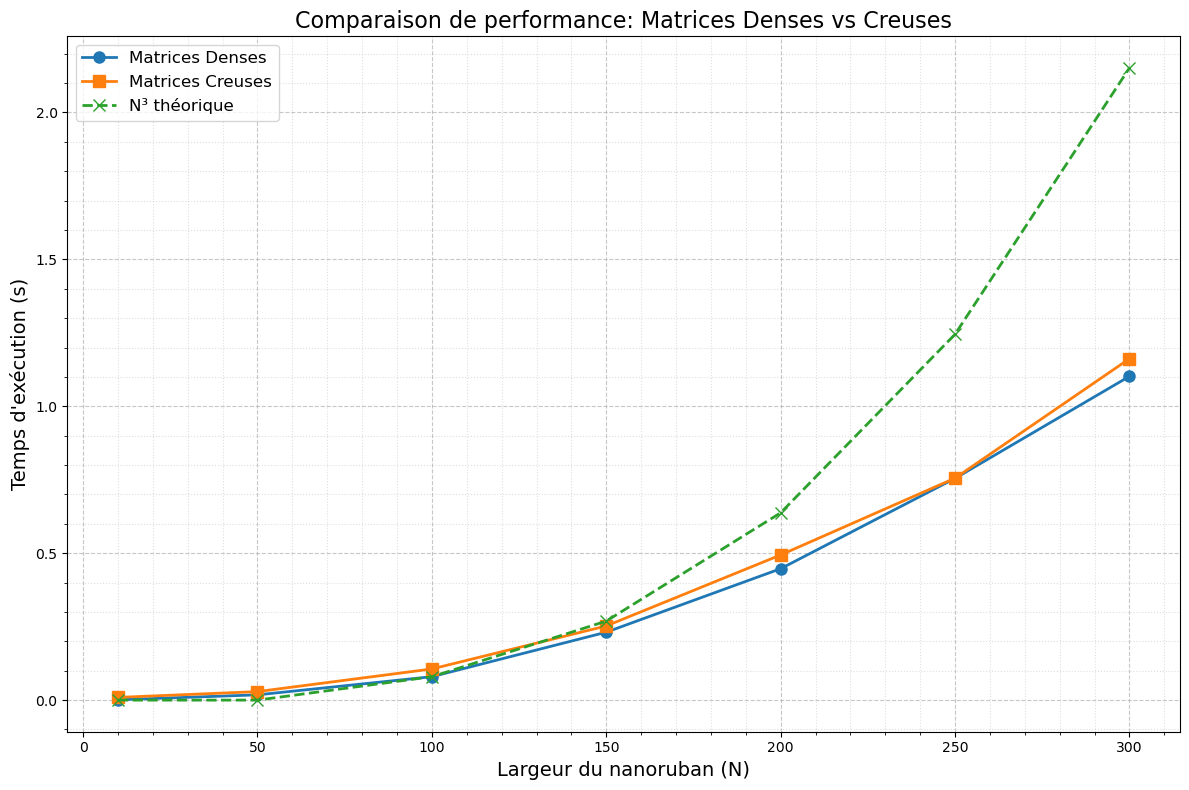

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ===== Implémentation avec matrices creuses =====
def construire_hamiltonien_zigzag_creux(k, N, t=1.0):
    """
    Construit la matrice Hamiltonienne H(k) pour un nanoruban zigzag en utilisant des matrices creuses.
    """
    dim = 2 * N

    # Nombre total d'éléments non-nuls
    nnz = 4*N - 2

    # Pré-allouer des tableaux numpy
    row_indices = np.zeros(nnz, dtype=np.int32)
    col_indices = np.zeros(nnz, dtype=np.int32)
    values = np.zeros(nnz, dtype=complex)

    # Terme de phase complexe
    gamma_k = 1 + np.exp(-1j * k)
    gamma_k_conj = np.conjugate(gamma_k)

    # Remplir les tableaux
    idx = 0

    # 1. Connexions intra-cellule
    for m in range(N):
        idx_a = 2 * m
        idx_b = 2 * m + 1

        # A -> B
        row_indices[idx] = idx_a
        col_indices[idx] = idx_b
        values[idx] = -t * gamma_k
        idx += 1

        # B -> A
        row_indices[idx] = idx_b
        col_indices[idx] = idx_a
        values[idx] = -t * gamma_k_conj
        idx += 1

    # 2. Connexions inter-cellule
    for m in range(N - 1):
        idx_b_m = 2 * m + 1
        idx_a_m_plus_1 = 2 * (m + 1)

        # B -> A (cellule suivante)
        row_indices[idx] = idx_b_m
        col_indices[idx] = idx_a_m_plus_1
        values[idx] = -t
        idx += 1

        # A (cellule suivante) -> B
        row_indices[idx] = idx_a_m_plus_1
        col_indices[idx] = idx_b_m
        values[idx] = -t
        idx += 1

    # Construire la matrice creuse au format CSR
    H = sp.csr_matrix((values, (row_indices, col_indices)), shape=(dim, dim), dtype=complex)
    return H

def calculer_bandes_zigzag_creux(N, t=1.0, num_k_points=50):
    """
    Calcule les énergies (valeurs propres) pour une plage de k de -pi à pi
    en utilisant des matrices creuses.
    """
    k_values = np.linspace(-np.pi, np.pi, num_k_points)
    dim = 2 * N
    eigenvalues = np.zeros((num_k_points, dim))

    for i, k in enumerate(k_values):
        # Construire la matrice hamiltonienne creuse
        Hk = construire_hamiltonien_zigzag_creux(k, N, t)

        # Pour s'assurer que la matrice est hermitienne
        H_hermitian = (Hk + Hk.getH()) / 2.0

        try:
            # Pour les petites valeurs de N, on peut calculer toutes les valeurs propres
            if N <= 100:
                vals = spla.eigsh(H_hermitian, k=dim, which='SA', return_eigenvectors=False)
            else:
                vals = spla.eigsh(H_hermitian, k=dim, which='SA', return_eigenvectors=False)
        except Exception as e:
            # Repli sur la méthode dense comme solution de secours
            vals = np.linalg.eigvalsh(H_hermitian.toarray())

        eigenvalues[i, :] = np.sort(vals.real)

    return k_values, eigenvalues

# ===== Implémentation avec matrices denses =====
def construire_hamiltonien_zigzag_dense(k, N, t=1.0):
    """
    Construit la matrice Hamiltonienne H(k) pour un nanoruban zigzag.
    Version dense originale pour comparaison.
    """
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=complex)
    gamma_k = 1 + np.exp(-1j * k)
    gamma_k_conj = np.conjugate(gamma_k)

    for m in range(N):
        idx_a = 2 * m
        idx_b = 2 * m + 1
        H[idx_a, idx_b] = -t * gamma_k
        H[idx_b, idx_a] = -t * gamma_k_conj

    for m in range(N - 1):
        idx_b_m = 2 * m + 1
        idx_a_m_plus_1 = 2 * (m + 1)
        H[idx_a_m_plus_1, idx_b_m] = -t
        H[idx_b_m, idx_a_m_plus_1] = -t

    return H

def calculer_bandes_zigzag_dense(N, t=1.0, num_k_points=50):
    """
    Calcule les énergies (valeurs propres) pour une plage de k de -pi à pi.
    Version dense originale pour comparaison.
    """
    k_values = np.linspace(-np.pi, np.pi, num_k_points)
    eigenvalues = np.zeros((num_k_points, 2 * N))

    for i, k in enumerate(k_values):
        Hk = construire_hamiltonien_zigzag_dense(k, N, t)
        vals = np.linalg.eigvalsh(Hk)
        eigenvalues[i, :] = vals

    return k_values, eigenvalues

# ===== Benchmark et comparaison de performance =====
def benchmark_performance(N_values, num_k_points=20):
    """
    Mesure les temps d'exécution pour différentes valeurs de N
    et retourne les données pour les graphiques.
    """
    # Préparer les tableaux pour stocker les résultats
    dense_times = []
    sparse_times = []
    theoretical_times = []  # Proportionnel à N^3

    # Référence pour ajuster la courbe théorique
    ref_N = 100
    ref_time_dense = None

    print(f"{'N':>5} | {'Dense (s)':>10} | {'Creuse (s)':>10} | {'Ratio':>6} | {'N³ Théorique':>12}")
    print(f"{'-'*5}-|-{'-'*10}-|-{'-'*10}-|-{'-'*6}-|-{'-'*12}")

    # Exécuter plusieurs fois pour avoir des mesures plus stables
    num_runs = 3

    for N in N_values:
        # Mesurer le temps pour la méthode dense (moyenne sur plusieurs exécutions)
        time_dense_total = 0
        for _ in range(num_runs):
            start_dense = time.time()
            _, _ = calculer_bandes_zigzag_dense(N, t=1.0, num_k_points=num_k_points)
            time_dense_total += time.time() - start_dense
        time_dense = time_dense_total / num_runs
        dense_times.append(time_dense)

        # Sauvegarder la référence pour N=100
        if N == ref_N:
            ref_time_dense = time_dense

        # Mesurer le temps pour la méthode creuse (moyenne sur plusieurs exécutions)
        time_sparse_total = 0
        for _ in range(num_runs):
            start_sparse = time.time()
            _, _ = calculer_bandes_zigzag_creux(N, t=1.0, num_k_points=num_k_points)
            time_sparse_total += time.time() - start_sparse
        time_sparse = time_sparse_total / num_runs
        sparse_times.append(time_sparse)

        # Calculer la valeur théorique
        if ref_time_dense is not None:
            theoretical_time = ref_time_dense * (N / ref_N) ** 3
            theoretical_times.append(theoretical_time)
        else:
            theoretical_time = 0
            theoretical_times.append(0)

        # Afficher les résultats
        speedup = time_dense / time_sparse if time_sparse > 0 else float('inf')
        print(f"{N:5d} | {time_dense:10.3f} | {time_sparse:10.3f} | {speedup:6.2f}x | {theoretical_time:12.3f}")

    return N_values, dense_times, sparse_times, theoretical_times

def tracer_comparaison(N_values, dense_times, sparse_times, theoretical_times):
    """
    Trace le graphique comparatif sans annotation d'accélération.
    """
    plt.figure(figsize=(12, 8))

    # Tracer les courbes
    plt.plot(N_values, dense_times, 'o-', linewidth=2, markersize=8, label='Matrices Denses', color='#1f77b4')
    plt.plot(N_values, sparse_times, 's-', linewidth=2, markersize=8, label='Matrices Creuses', color='#ff7f0e')

    if theoretical_times:
        plt.plot(N_values, theoretical_times, 'x--', linewidth=2, markersize=8, label='N³ théorique', color='#2ca02c')

    # Configurer le graphique
    plt.title('Comparaison de performance: Matrices Denses vs Creuses', fontsize=16)
    plt.xlabel('Largeur du nanoruban (N)', fontsize=14)
    plt.ylabel('Temps d\'exécution (s)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Ajouter une grille mineure
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', alpha=0.4)

    # Améliorer la lisibilité
    plt.tight_layout()

    return plt

def main():
    # Valeurs de N à tester
    N_values = [10, 50, 100, 150, 200, 250, 300]

    # Nombre de points k (réduit pour accélérer le benchmark)
    num_k_points = 20

    print(f"Démarrage du benchmark avec {num_k_points} points k...")
    print(f"Exécution de tests sur différentes tailles de nanoruban: {N_values}")
    N_values, dense_times, sparse_times, theoretical_times = benchmark_performance(N_values, num_k_points)

    print("\nTracé du graphique comparatif...")
    plt_obj = tracer_comparaison(N_values, dense_times, sparse_times, theoretical_times)
    plt_obj.savefig('comparaison_performance.png', dpi=300)
    print("Graphique sauvegardé sous 'comparaison_performance.png'")

    # Imprimer l'analyse des écarts par rapport à la théorie
    print("\nAnalyse des écarts par rapport à la théorie N³:")
    for i, N in enumerate(N_values):
        if theoretical_times[i] > 0:
            ecart_dense = (dense_times[i] / theoretical_times[i] - 1) * 100
            ecart_sparse = (sparse_times[i] / theoretical_times[i] - 1) * 100
            print(f"N = {N}: Écart Dense: {ecart_dense:+.1f}%, Écart Creux: {ecart_sparse:+.1f}%")

    plt_obj.show()

if __name__ == "__main__":
    main()

# Calcul de la Densité d'États (DOS)

Après avoir obtenu la structure de bandes $E_n(k)$, qui donne les énergies permises pour chaque vecteur d'onde $k$ et chaque bande $n$, nous pouvons calculer la Densité d'États (DOS), notée $D(E)$. La DOS représente le nombre d'états électroniques disponibles par unité d'énergie, à une énergie donnée $E$. Elle est formellement définie comme :

$$
D(E) = \frac{1}{\mathcal{N}} \sum_{n, k} \delta(E - E_n(k))
$$

où la somme porte sur toutes les bandes $n$ et tous les vecteurs d'onde $k$ permis dans la première zone de Brillouin, $\delta$ est la fonction delta de Dirac, et $\mathcal{N}$ est un facteur de normalisation (souvent lié au nombre total de points $k$ ou au volume du système).

**Approximation Numérique (Histogramme)**

Pour calculer la DOS numériquement, nous remplaçons la somme sur $k$ par une somme sur un échantillonnage discret de points $k$ dans la zone de Brillouin (ici, $k$ variant de $-\pi$ à $\pi$) et nous approximons la fonction delta. Une méthode courante est l'histogramme :

1.  **Calcul des Énergies :** Nous calculons les valeurs propres $E_n(k)$ de la matrice $H(k)$ pour un grand nombre de points $k$ (`num_k_points`) répartis uniformément entre $-\pi$ et $\pi$. Cela nous donne un ensemble de $N_{\text{total}} = \text{num\_k\_points} \times (2N)$ valeurs d'énergie.
2.  **Création des Bacs (Bins) :** Nous définissons une plage d'énergie couvrant toutes les valeurs $E_n(k)$ calculées et la divisons en un certain nombre de petits intervalles (bacs ou bins) de largeur $\Delta E$.
3.  **Comptage :** Nous comptons combien d'énergies $E_n(k)$ tombent dans chaque bac d'énergie.
4.  **Normalisation :** Pour obtenir la densité, le nombre d'états dans chaque bac est divisé par le nombre total de $k$-points utilisés et par la largeur du bac $\Delta E$. Une alternative simple consiste à utiliser l'option `density=True` de la fonction `numpy.histogram`, qui normalise l'histogramme de sorte que son intégrale totale soit égale à 1. Pour obtenir une DOS dont l'intégrale est égale au nombre total de bandes (2N), une mise à l'échelle supplémentaire serait nécessaire, mais pour visualiser la forme de la DOS, la normalisation `density=True` est souvent suffisante.

Le code ci-dessous implémente cette méthode par histogramme et ajoute le tracé de la DOS à côté de la structure de bandes dans la visualisation interactive. Des pics dans la DOS correspondent généralement à des régions où les bandes sont plates (faible dépendance de $E$ en fonction de $k$, comme les états de bord près de $E=0$ pour les rubans zigzag) ou à des points de Van Hove (extrema ou points selle dans la structure de bandes).

N = 2, Consommation mémoire de pic : 0.0435 MB
N = 22, Consommation mémoire de pic : 0.5493 MB
N = 42, Consommation mémoire de pic : 1.0116 MB
N = 62, Consommation mémoire de pic : 1.5725 MB
N = 82, Consommation mémoire de pic : 2.2295 MB
N = 102, Consommation mémoire de pic : 2.9844 MB
N = 122, Consommation mémoire de pic : 3.8354 MB
N = 142, Consommation mémoire de pic : 4.7867 MB
N = 162, Consommation mémoire de pic : 5.8335 MB
N = 182, Consommation mémoire de pic : 6.9797 MB
N = 202, Consommation mémoire de pic : 8.2229 MB
N = 222, Consommation mémoire de pic : 9.5622 MB

--- Ajustement théorique ---
Mémoire(N) ≈ 0.000186 * N^2 + 0.741729


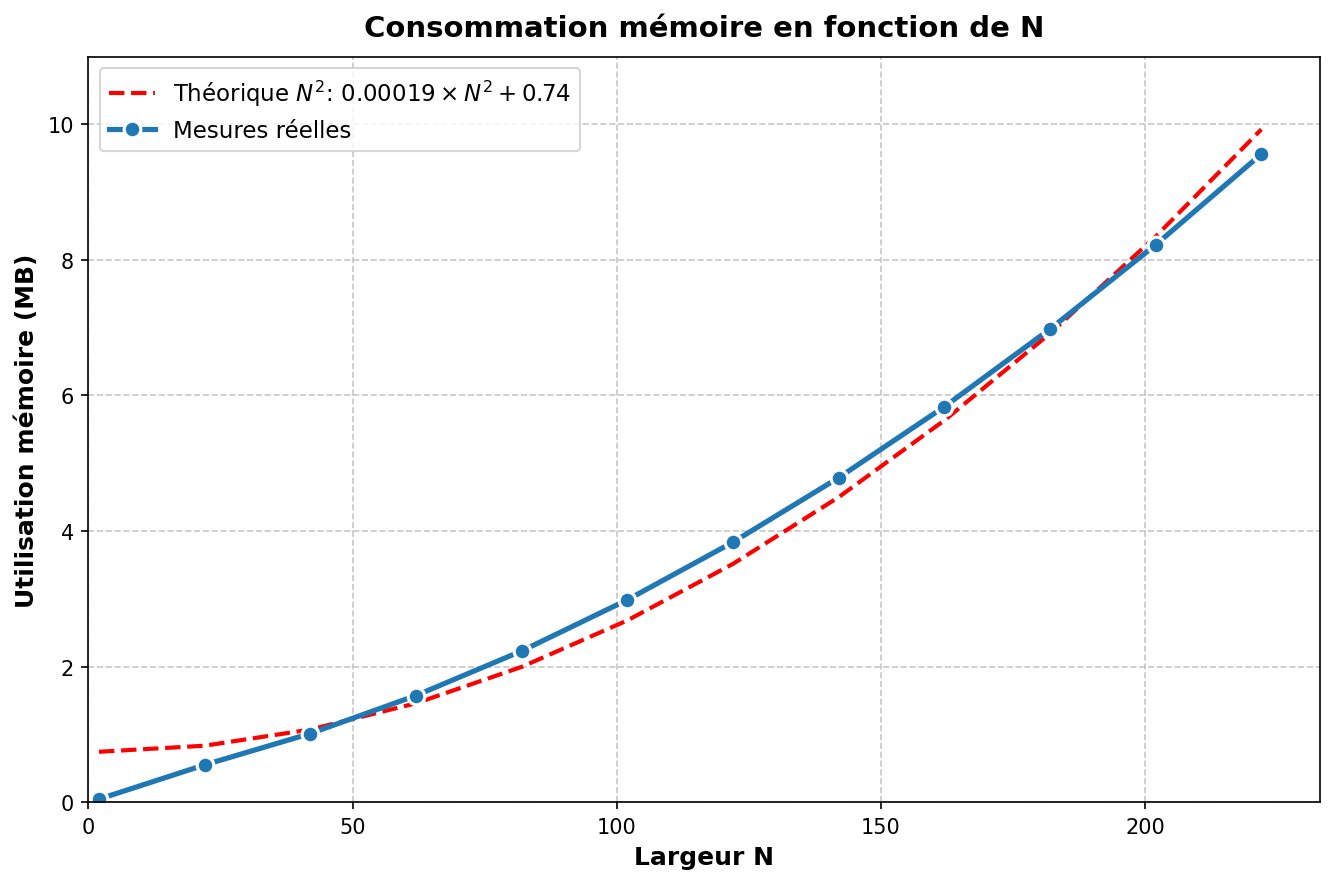

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc



def construire_hamiltonien_zigzag(k, N, t=1.0):
    """
    Construit la matrice Hamiltonienne H(k) pour un nanoruban zigzag.
    """
    dim = 2 * N
    H = np.zeros((dim, dim), dtype=complex)
    gamma_k = 1 + np.exp(-1j * k)
    gamma_k_conj = np.conjugate(gamma_k)

    for m in range(N):
        idx_a = 2 * m
        idx_b = 2 * m + 1
        H[idx_a, idx_b] = -t * gamma_k
        H[idx_b, idx_a] = -t * gamma_k_conj

    for m in range(N - 1):
        idx_b_m = 2 * m + 1
        idx_a_m_plus_1 = 2 * (m + 1)
        H[idx_a_m_plus_1, idx_b_m] = -t
        H[idx_b_m, idx_a_m_plus_1] = -t

    return H

def calculer_bandes_zigzag(N, t=1.0, num_k_points=1000):
    """
    Calcule les énergies (valeurs propres) pour une plage de k.
    """
    k_values = np.linspace(np.pi, np.pi, num_k_points)
    eigenvalues = np.zeros((num_k_points, 2 * N))

    for i, k in enumerate(k_values):
        Hk = construire_hamiltonien_zigzag(k, N, t)
        vals = np.linalg.eigvalsh(Hk)
        eigenvalues[i, :] = vals

    return k_values, eigenvalues

def tracer_bandes(k_values, eigenvalues, N, t=1.0):
    """
    Trace la structure de bandes de -π à π (selon la définition de k_values).
    """
    num_bands = eigenvalues.shape[1]
    # Pour affichage en unité de π
    k_labels = k_values / np.pi

    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(k_labels, eigenvalues[:, i] / t, color='blue', linewidth=1.5)

    plt.xlabel(r'$k a / \pi$')
    plt.ylabel(r'$E / t$')
    plt.title(f'Structure de Bandes - Nanoruban Zigzag (N = {N})')

    min_E = np.min(eigenvalues / t)
    max_E = np.max(eigenvalues / t)
    plt.ylim(min(min_E - 0.2, -t*3.2), max(max_E + 0.2, t*3.2))
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='E = 0')
    plt.axvline(x=-2/3, color='gray', linestyle=':', linewidth=0.8)
    plt.axvline(x=2/3, color='gray', linestyle=':', linewidth=0.8)

    plt.xticks([-1, -2/3, 0, 2/3, 1],
               [r'$-\pi$', r'$-2\pi/3$', '0', r'$2\pi/3$', r'$\pi$'])

    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()

# --------------------------------------------------------------------
#            Mesure de la consommation mémoire (tracemalloc)
# --------------------------------------------------------------------

def measure_memory_usage(N, t=1.0, num_k_points=1000):
    """
    Mesure la consommation mémoire de la fonction calculer_bandes_zigzag pour une largeur N donnée
    en utilisant le module tracemalloc. Retourne la valeur (en MB).
    """
    tracemalloc.start()
    k_values, eigenvalues = calculer_bandes_zigzag(N, t=t, num_k_points=num_k_points)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    # Conversion en mégaoctets
    return peak / (1024 ** 2)



Ns = np.arange(2, 240, 20)
# => [2, 32, 62, 92, 122, 152, 182, 212, 242]

memory_usage = []

# Mesure de la mémoire pour chaque N
for N in Ns:
    mem = measure_memory_usage(N)
    print(f"N = {N}, Consommation mémoire de pic : {mem:.4f} MB")
    memory_usage.append(mem)

# --------------------------------------------------------------------
#       Ajustement théorique : on suppose un scaling ~ N^2
#       On effectue un ajustement linéaire : mem ~ a*(N^2) + b
# --------------------------------------------------------------------
coeffs = np.polyfit(Ns**2, memory_usage, 1)
# coeffs[0] = a, coeffs[1] = b
memory_theory = coeffs[0] * (Ns**2) + coeffs[1]

print("\n--- Ajustement théorique ---")
print(f"Mémoire(N) ≈ {coeffs[0]:.6f} * N^2 + {coeffs[1]:.6f}")

# --------------------------------------------------------------------
#       Tracé comparatif amélioré (données mesurées vs. loi ~ N^2)
# --------------------------------------------------------------------

# Configuration matplotlib pour un graphique plus attrayant
plt.figure(figsize=(9, 6), dpi=150)

# Tracé de la courbe théorique avec un style amélioré
plt.plot(Ns, memory_theory, 'r--', linewidth=2,
         label=r'Théorique $N^2$: $%.5f \times N^2 + %.2f$' % (coeffs[0], coeffs[1]))

# Tracé des mesures réelles avec un style amélioré
plt.plot(Ns, memory_usage, 'o-', color='#1f77b4', linewidth=2.5, markersize=8,
         markerfacecolor='#1f77b4', markeredgecolor='white', markeredgewidth=1.5,
         label='Mesures réelles')

# Amélioration des labels et du titre
plt.title("Consommation mémoire en fonction de N", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Largeur N", fontsize=12, fontweight='bold')
plt.ylabel("Utilisation mémoire (MB)", fontsize=12, fontweight='bold')

# Amélioration de la grille
plt.grid(True, linestyle='--', alpha=0.7)

# Amélioration de la légende
plt.legend(loc='upper left', frameon=True, fontsize=11)

# Personnalisation des axes
plt.ylim(0, max(memory_usage) * 1.15)  # Un peu d'espace en haut
plt.xlim(0, max(Ns) * 1.05)            # Un peu d'espace à droite

# Sauvegarde pour PowerPoint
plt.tight_layout()
plt.savefig("consommation_memoire_ameliore.png", dpi=150)

plt.show()